# Installation der requirements
!pip install pygraphviz
!pip install pandas
!pip install pyarrow
!pip install seaborn
!pip install scikit-learn
'pip install tensorflow

In [1]:
# Import der Libraries
import math
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import pygraphviz as pgv
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Laden des Datensets
df = pd.read_csv('Cleaned_data.csv')
df.head()

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage
0,2020-12-01 06:56:44.000,Montage BAU 3 UG,F710SPS1,105600,UB75SPS2,92.050000,True,3,UG
1,2020-12-01 07:13:10.000,Montage BAU 2 1.OG,AS71SPS1,105600,F710SPS1,16.433333,True,2,OG
2,2020-12-01 07:18:14.000,Montage BAU 2 1.OG,AS72SPS1,105600,AS71SPS1,5.066667,False,2,OG
3,2020-12-01 07:32:51.000,Montage BAU 3 UG,F720SPS1,105600,AS72SPS1,14.616667,True,3,UG
4,2020-12-01 07:35:05.000,Montage BAU 2 1.OG,FS71SPS1,105600,F720SPS1,2.233333,True,2,OG


In [3]:
feature_range=(df['Verweildauer'].min(), df['Verweildauer'].max())
feature_range

(0.1333333333333333, 6382.283333333334)

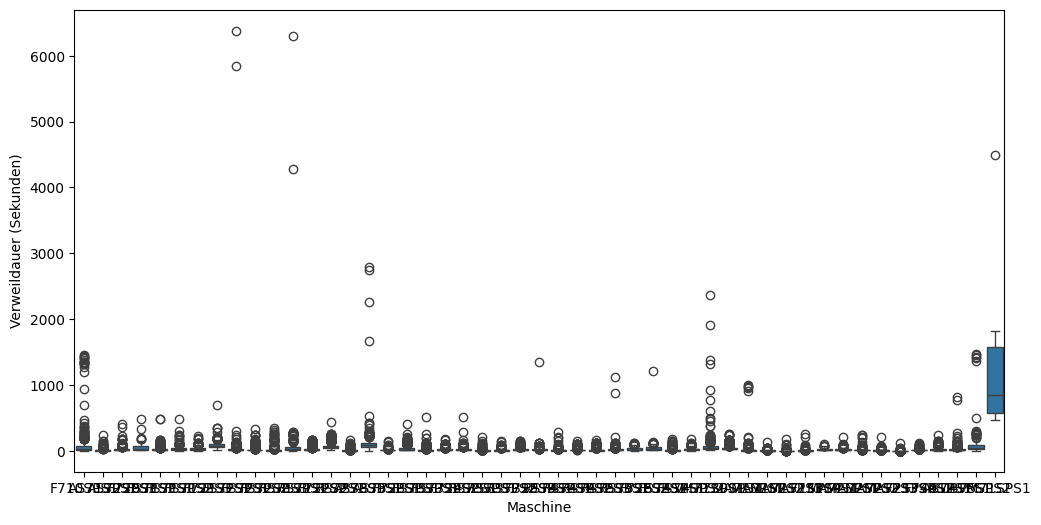

In [13]:
# Boxplot der Verweildauer für jede Maschine erstellen
sns.boxplot(x="Maschine", y="Verweildauer", data=df)
plt.xlabel("Maschine")
plt.ylabel("Verweildauer (Sekunden)")
plt.gcf().set_size_inches((12, 6))  # Erhöht die Breite auf 10 Zoll
plt.savefig('Verweildauer.png')
plt.show()

In [15]:
# Berechnung des Interquartilbereichs (IQR)
Q1 = df['Verweildauer'].quantile(0.25)
Q3 = df['Verweildauer'].quantile(0.75)
IQR = Q3 - Q1

# Definieren des unteren und oberen Schwellenwerts für Ausreißer
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Filtern der Einträge, die innerhalb des IQR liegen
df = df[(df['Verweildauer'] >= lower_threshold) & (df['Verweildauer'] <= upper_threshold)]

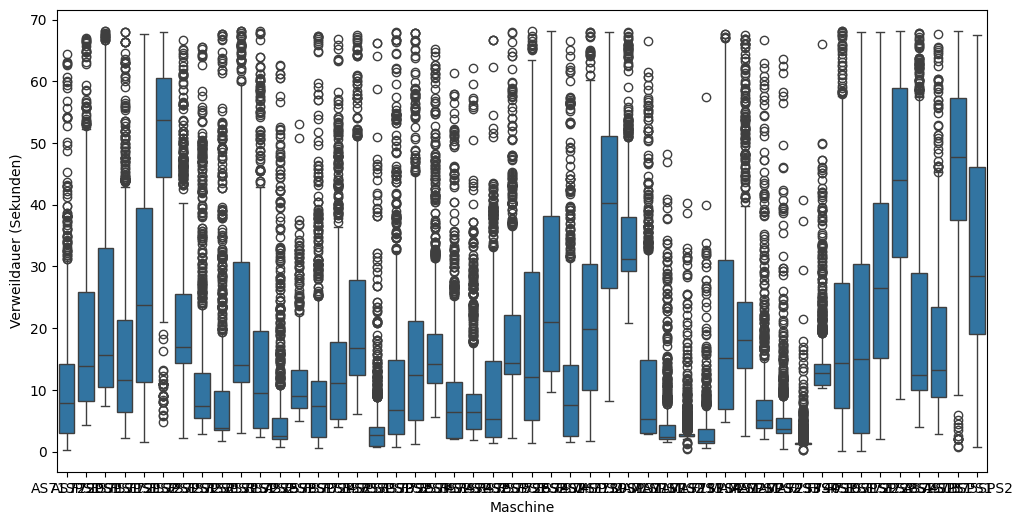

In [17]:
# Boxplot der Verweildauer für jede Maschine erstellen
sns.boxplot(x="Maschine", y="Verweildauer", data=df)
plt.xlabel("Maschine")
plt.ylabel("Verweildauer (Sekunden)")
plt.gcf().set_size_inches((12, 6))  # Erhöht die Breite auf 10 Zoll
plt.savefig('Verweildauer2.png')
plt.show()

In [19]:
df_sorted_by_time = df.copy()
df_sorted_by_time['Zeitpunkt'] = pd.to_datetime(df_sorted_by_time['Zeitpunkt'])
df_sorted_by_time = df_sorted_by_time.sort_values(by=['Zeitpunkt'], ascending=True).reset_index(drop=True)
df_sorted_by_time

df_sorted_by_time.to_csv('data_ready_for_LSTM_IQR.csv', index=False)
df_sorted_by_time

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage
0,2020-11-30 00:07:36,Montage BAU 2 1.OG,RS72SPS1,200060,F722SPS1,6.083333,True,2,OG
1,2020-11-30 00:14:42,Montage BAU 2 1.OG,RS72SPS1,201078,F722SPS1,2.716667,True,2,OG
2,2020-11-30 00:29:19,Montage BAU 2 1.OG,RS71SPS1,200465,FS72SPS2,28.183333,False,2,OG
3,2020-11-30 00:33:46,Montage BAU 3 UG,F740SPS1,201442,F733SPS1,26.050000,False,3,UG
4,2020-11-30 00:36:30,Montage BAU 2 1.OG,RS72SPS1,201181,F722SPS1,2.383333,True,2,OG
...,...,...,...,...,...,...,...,...,...
53417,2020-12-05 12:52:00,BAU 2 2.OG,RS75SPS2,200216,RS75SPS1,7.100000,False,2,OG
53418,2020-12-05 13:07:09,BAU 2 2.OG,RS73SPS3,200130,RS73SPS2,40.866667,False,2,OG
53419,2020-12-05 13:20:36,Montage BAU 3 UG,F725SPS1,200130,RS73SPS3,13.450000,True,3,UG
53420,2020-12-05 15:37:40,Montage BAU 2 1.OG,AS75SPS1,201701,AS73SPS1,53.016667,False,2,OG


In [25]:
len(dfML['Maschine'].unique())

48

In [24]:
dfML = pd.read_csv('data_ready_for_LSTM_IQR.csv')

dfML['Zeitpunkt'] = pd.to_datetime(dfML['Zeitpunkt'])
dfML = dfML.sort_values(by=['Zeitpunkt'], ascending=True).reset_index(drop=True)

le_maschine = joblib.load("le_maschine.pkl")
dfML['Maschine_encoded'] = le_maschine.transform(dfML['Maschine'])
dfML['Herkunft_encoded'] = le_maschine.transform(dfML['Herkunft'])
le_bau = joblib.load("le_bau.pkl")
dfML['BAU_encoded'] = le_bau.transform(dfML['BAU'])
le_etage = joblib.load("le_etage.pkl")
dfML['Etage_encoded'] = le_etage.transform(dfML['Etage'])
dfML['Area_Wechsel_encoded'] = dfML['Area_Wechsel'].astype(int)
dfML['Zeitpunkt_encoded'] = pd.to_datetime(dfML['Zeitpunkt']).astype('int64') // 10**9

# Normalisierung der numerischen Variablen ('Verweildauer')
sc_verweildauer = joblib.load("sc_verweildauer.pkl")
dfML['Verweildauer_scaled'] = sc_verweildauer.transform(dfML['Verweildauer']
                                                        .values.reshape(-1, 1))

dfML

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage,Maschine_encoded,Herkunft_encoded,BAU_encoded,Etage_encoded,Area_Wechsel_encoded,Zeitpunkt_encoded,Verweildauer_scaled
0,2020-11-30 00:07:36,Montage BAU 2 1.OG,RS72SPS1,200060,F722SPS1,6.083333,True,2,OG,38,8,0,0,1,1606694856,-0.246225
1,2020-11-30 00:14:42,Montage BAU 2 1.OG,RS72SPS1,201078,F722SPS1,2.716667,True,2,OG,38,8,0,0,1,1606695282,-0.378858
2,2020-11-30 00:29:19,Montage BAU 2 1.OG,RS71SPS1,200465,FS72SPS2,28.183333,False,2,OG,36,21,0,0,0,1606696159,0.624425
3,2020-11-30 00:33:46,Montage BAU 3 UG,F740SPS1,201442,F733SPS1,26.050000,False,3,UG,16,15,1,2,0,1606696426,0.540381
4,2020-11-30 00:36:30,Montage BAU 2 1.OG,RS72SPS1,201181,F722SPS1,2.383333,True,2,OG,38,8,0,0,1,1606696590,-0.391989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53417,2020-12-05 12:52:00,BAU 2 2.OG,RS75SPS2,200216,RS75SPS1,7.100000,False,2,OG,46,45,0,0,0,1607172720,-0.206172
53418,2020-12-05 13:07:09,BAU 2 2.OG,RS73SPS3,200130,RS73SPS2,40.866667,False,2,OG,41,40,0,0,0,1607173629,1.124097
53419,2020-12-05 13:20:36,Montage BAU 3 UG,F725SPS1,200130,RS73SPS3,13.450000,True,3,UG,11,41,1,2,1,1607174436,0.043992
53420,2020-12-05 15:37:40,Montage BAU 2 1.OG,AS75SPS1,201701,AS73SPS1,53.016667,False,2,OG,4,2,0,0,0,1607182660,1.602758


In [27]:
# Umwandlung der Daten in Sequenzen für das LSTM-Modell
def train_test_split(X, y, sequence_length): 
    sequences = []
    for i in range(len(X) - sequence_length):
        sequences.append(X[i:i+sequence_length])
    
    # Aufteilen der Daten in Trainings- und Testsets
    X_train = np.array(sequences[:int(len(sequences)*0.8)])
    X_test = np.array(sequences[int(len(sequences)*0.8):])
    y_train = y[sequence_length:int(len(sequences)*0.8)+sequence_length]
    y_test = y[int(len(sequences)*0.8)+sequence_length:]

    return X_train, X_test, y_train, y_test

In [28]:
def calc_mse(model, X_test, y_test):
    # Vorhersagen mit dem trainierten Modell
    predictions = model.predict(X_test)

    # Umkehrung der Skalierung der Vorhersagen
    predictions_unscaled = sc_verweildauer.inverse_transform(predictions)
    
    # Umkehrung der Skalierung der wahren Werte
    y_test_unscaled = sc_verweildauer.inverse_transform(y_test.
                                                        reshape(-1, 1))
    
    # Berechnung des MSE in absoluten Einheiten (Sekunden)
    mse_absolute = mean_squared_error(y_test_unscaled, 
                                      predictions_unscaled)
    print('Mean Squared Error:', mse_absolute)
    # Ausgabe des RMSE
    print("RMSE - Durchschnittliche Abweichung (in Sekunden):", 
          math.sqrt(mse_absolute))

In [29]:
def plot_history(history):
    # Plot von Trainings- und Validierungsloss
    plt.plot(history.history['loss'], label='Trainingsloss')
    plt.plot(history.history['val_loss'], label='Validierungsloss')
    plt.title('Trainings- und Validierungsloss')
    plt.xlabel('Epochen')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [43]:
def train(sequence_length, features, learning_rate, drop_out, batch_size, 
          epochs, estopping, optimizer='adam', loss='mean_squared_error'):
    X = dfML[features].values
    y = dfML['Verweildauer_scaled'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, sequence_length)

    # Erstellen des LSTM-Modells
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(drop_out))
    model.add(LSTM(units=32))
    model.add(Dropout(drop_out))
    model.add(Dense(units=1))

    # Definieren Sie den Adam-Optimizer mit einer angepassten Lernrate
    custom_optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=loss)
    # Definieren Sie den EarlyStopping-Callback
    early_stopping = EarlyStopping(monitor='val_loss',  
                                   patience=estopping,         
                                   restore_best_weights=True)  
    
    # Training des Modells
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_split=0.2, callbacks=[early_stopping])
    
    # Bewertung des Modells
    score = model.evaluate(X_test, y_test)
    print('Test Loss:', score)
    plot_history(history)

    calc_mse(model, X_test, y_test)
    return model

Epoch 1/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4073 - val_loss: 0.4255
Epoch 2/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3844 - val_loss: 0.4289
Epoch 3/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3809 - val_loss: 0.4258
Epoch 4/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3849 - val_loss: 0.4255
Epoch 5/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3914 - val_loss: 0.4272
Epoch 6/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3819 - val_loss: 0.4264
Epoch 7/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3835 - val_loss: 0.4259
Epoch 8/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3834 - val_loss: 0.4250
Epoch 9/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3873 - val_loss: 0.4250
Epoch 10/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3830 - val_loss: 0.4244
Epoch 11/50
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3835 - val_loss: 0.4247
Epoch 12/50
1069/1069 ━━━━━━━━

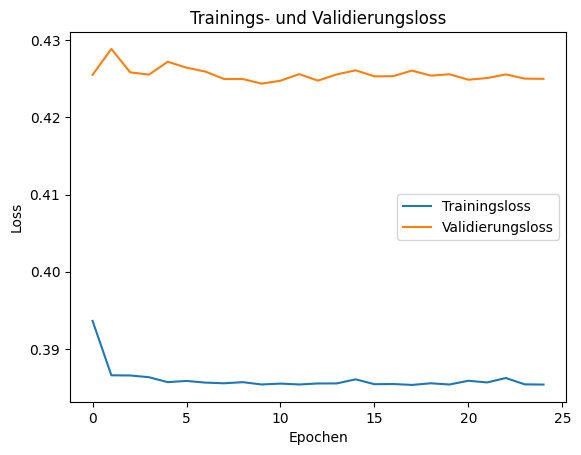

334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error: 236.95030356548617
RMSE - Durchschnittliche Abweichung (in Sekunden): 15.393190168561102


In [46]:
# Festlegung der Eingabevariablen (Features) und der Zielvariable
features = ['Zeitpunkt_encoded', 'Maschine_encoded', 'Herkunft_encoded', 'BAU_encoded', 'Etage_encoded']
model = train(sequence_length=10, 
              features=features, 
              learning_rate=0.01,
              drop_out=0.2, 
              batch_size=32, 
              epochs=50, 
              estopping=15)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.4048 - val_loss: 0.4247
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3828 - val_loss: 0.4259
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3843 - val_loss: 0.4223
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3804 - val_loss: 0.4252
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3772 - val_loss: 0.4236
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.3795 - val_loss: 0.4234
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3790 - val_loss: 0.4259
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.3798 - val_loss: 0.4256
Epoch 9/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3798 - val_loss: 0.4233
Epoch 10/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.3786 - val_loss: 0.4257
Epoch 11/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.3820 - val_loss: 0.4260
Epoch 12/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 

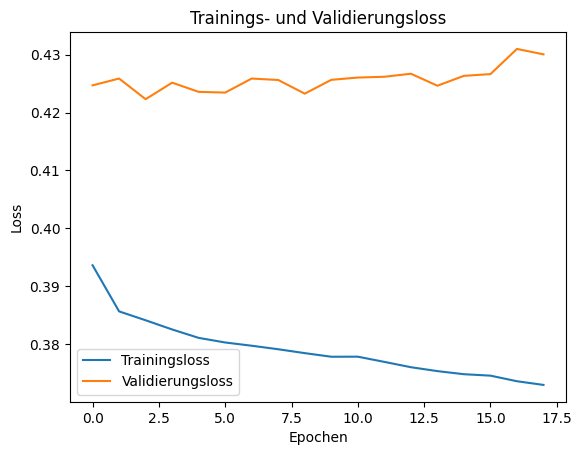

334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Mean Squared Error: 232.03225556770528
RMSE - Durchschnittliche Abweichung (in Sekunden): 15.232605015810831


In [48]:
# Festlegung der Eingabevariablen (Features) und der Zielvariable
features = ['Maschine_encoded', 'Herkunft_encoded', 'BAU_encoded', 'Etage_encoded']
model = train(sequence_length=25, 
              features=features, 
              learning_rate=0.01,
              drop_out=0.3, 
              batch_size=64, 
              epochs=50, 
              estopping=15)
model.save('LSTM_Process_Mining_2.keras')

Epoch 1/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.4093 - val_loss: 0.4218
Epoch 2/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.3891 - val_loss: 0.4220
Epoch 3/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.3830 - val_loss: 0.4213
Epoch 4/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.3864 - val_loss: 0.4224
Epoch 5/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.3835 - val_loss: 0.4234
Epoch 6/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.3829 - val_loss: 0.4241
Epoch 7/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.3733 - val_loss: 0.4247
Epoch 8/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.3733 - val_loss: 0.4236
Epoch 9/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.3749 - val_loss: 0.4223
Epoch 10/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.3811 - val_loss: 0.4265
Epoch 11/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.3741 - val_loss: 0.4251
Epoch 12/100
534/53

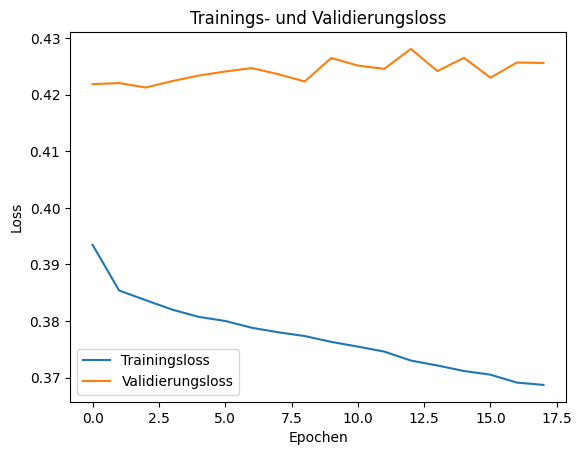

334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean Squared Error: 236.09528319677133
RMSE - Durchschnittliche Abweichung (in Sekunden): 15.365392386684153


In [47]:
# Festlegung der Eingabevariablen (Features) und der Zielvariable
features = ['Maschine_encoded', 'Herkunft_encoded', 'BAU_encoded', 'Etage_encoded']
model = train(sequence_length=50, 
              features=features, 
              learning_rate=0.005,
              drop_out=0.3, 
              batch_size=64, 
              epochs=50, 
              estopping=15)
model.save('LSTM_Process_Mining_3.keras')